__Update: Following the suggestion by @adityaecdrid and @jackwei (thanks!) I have added a comparison between different implementations of sequence bucketing including the one used in [@authmans great kernel](https://www.kaggle.com/authman/simple-lstm-pytorch-with-batch-loading) and changed the sequence bucketing method used as a result of this.__

# Preface

In this kernel, I am going to give you an overview of sequence bucketing. I was not able to find a good, simple tutorial for this so I decided to make one myself. 

In RNNs, the input sequences are often all padded to the same length by doing something along the lines of this:

`x_train = pad_sequences(x_train, maxlen=MAX_LEN)`

This is suboptimal because when iterating over the dataset in batches, there will be some batches where the length of all samples is smaller than `MAX_LEN`. So there will be tokens which are zero everywhere in the batch but are still processed by the RNN. Using sequence bucketing, we can speed this up by dynamically padding every batch to the maximum sequence length which occurs in that batch. Or to e. g. the 95th percentile of lengths in that batch.

To avoid confusion, you should refer to this practice as *sequence bucketing*, not just bucketing. "Bucketing" is often used synonimously to quantization, binning or discretization. [When googling "bucketing machine learning" you find results for a mix of both meanings which can be very confusing](http://lmgtfy.com/?q=bucketing+machine+learning).

The preprocessing and neural network architecture is taken from the best scoring public kernel at the time of writing: [Simple LSTM with Identity Parameters - Fast AI](https://www.kaggle.com/kunwar31/simple-lstm-with-identity-parameters-fastai). Up to the tokenization using the keras tokenizer, the code is exactly the same, so I have hidden it.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import fastai
from fastai.train import Learner
from fastai.train import DataBunch
from fastai.callbacks import *
from fastai.basic_data import DatasetType
import fastprogress
from fastprogress import force_console_behavior
import numpy as np
from pprint import pprint
import pandas as pd
import os
import time
import gc
import random
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import seaborn as sns

sns.set_style('whitegrid')

Using TensorFlow backend.


In [2]:
# disable progress bars when submitting
def is_interactive():
   return 'SHLVL' not in os.environ

if not is_interactive():
    def nop(it, *a, **k):
        return it

    tqdm = nop

    fastprogress.fastprogress.NO_BAR = True
    master_bar, progress_bar = force_console_behavior()
    fastai.basic_train.master_bar, fastai.basic_train.progress_bar = master_bar, progress_bar

In [3]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

CRAWL_EMBEDDING_PATH = '../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = '../input/glove840b300dtxt/glove.840B.300d.txt'
NUM_MODELS = 2
LSTM_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 220

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        emb_arr = []
        for line in tqdm(f):
            try:
                emb_arr.append(get_coefs(*line.strip().split(' ')))
            except Exception as e:
                print(e)
                               
        return dict(emb_arr)

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T), some features are masked
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

def train_model(learn,test,output_dim,lr=0.001,
                batch_size=512, n_epochs=4,
                enable_checkpoint_ensemble=True):
    
    all_test_preds = []
    checkpoint_weights = [2 ** epoch for epoch in range(n_epochs)]
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n).schedule_hp('lr', lr * (0.6**(i)))) for i in range(n_epochs)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    for epoch in range(n_epochs):
        learn.fit(1)
        test_preds = np.zeros((len(test), output_dim))    
        for i, x_batch in enumerate(test_loader):
            X = x_batch[0].cuda()
            y_pred = sigmoid(learn.model(X).detach().cpu().numpy())
            test_preds[i * batch_size:(i+1) * batch_size, :] = y_pred

        all_test_preds.append(test_preds)


    if enable_checkpoint_ensemble:
        test_preds = np.average(all_test_preds, weights=checkpoint_weights, axis=0)    
    else:
        test_preds = all_test_preds[-1]
        
    return test_preds

train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

x_train = preprocess(train['comment_text'])
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = preprocess(test['comment_text'])

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
# Overall
weights = np.ones((len(x_train),)) / 4
# Subgroup
weights += (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4
# Background Positive, Subgroup Negative
weights += (( (train['target'].values>=0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
# Background Negative, Subgroup Positive
weights += (( (train['target'].values<0.5).astype(bool).astype(np.int) +
   (train[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
loss_weight = 1.0 / weights.mean()

y_train = np.vstack([(train['target'].values>=0.5).astype(np.int),weights]).T

max_features = None

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

max_features = max_features or len(tokenizer.word_index) + 1
max_features

embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
embedding_matrix.shape

del crawl_matrix
del glove_matrix
gc.collect()

# x_train_torch = torch.tensor(x_train, dtype=torch.long)
y_train_torch = torch.tensor(np.hstack([y_train, y_aux_train]), dtype=torch.float32)

n unknown words (crawl):  174141
n unknown words (glove):  170837


# Sequence Bucketing

In [4]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

So now we have `x_train` and `x_test`, both Python lists consisting of a list with tokens for each sample.

In [5]:
x_train[0]

[21,
 6,
 36,
 2224,
 9,
 13,
 53,
 44,
 11,
 107,
 38,
 1059,
 2,
 194,
 21,
 126,
 167,
 365,
 96,
 226]

First, I am going to take a look at the expected length of each batch with different batch sizes when using sequence bucketing and see how it compares to the fixed length of 220 to which the sequences were previously padded in the kernel.

In [6]:
lengths = np.array([len(x) for x in x_train])

The function `plot_expected_lengths` samples a number of batches (per default 10000) of a specific batch size from the given lengths, and checks which length this batch would be padded to when using some function `choose_length`. `choose_length` has to return the length which will be padded to given an array of lengths in a batch. In the simplest case, this would be `lambda lengths: lengths.max()`. It could also be `lambda lengths: np.percentile(lengths, q=95)` to pad to the 95th percentile of lengths in a batch.

The lengths each of those 10000 batches are padded to are then plotted as a histogram, and the mean of all lengths with this batch size is plotted as a green line. This length can then be compared to the fixed length (shown in red) which the dataset was previously padded to.

In [7]:
def plot_expected_lengths(lengths, batch_sizes, choose_length, markers=[], n_batches=10000):
    fig, axarr = plt.subplots(len(batch_sizes), 1, figsize=(14, 20), sharex=True)
    expected_lengths = {}
    
    for i, batch_size in enumerate(batch_sizes):
        maxs = []

        for _ in tqdm(range(n_batches), disable=False):
            val = choose_length(np.random.choice(lengths, batch_size))
            maxs.append(math.ceil(val))

        pd.Series(maxs).plot.hist(bins=50, ax=axarr[i], density=True, color='black', edgecolor='white', alpha=0.1)
        expected = np.mean(maxs)
        expected_lengths[batch_size] = expected
        
        max_y = axarr[i].get_ylim()[1]
        
        axarr[i].vlines([expected], 0, 1e3, 'limegreen', lw=4)
        axarr[i].set_ylim([0, max_y])
        axarr[i].set_xlim([0, max(lengths)])
        axarr[i].set_ylabel(f'batch_size={batch_size}', rotation=0)
        axarr[i].yaxis.set_label_coords(-0.1, 0.45)
        axarr[i].set_yticks([])

    for marker in markers:
        con = ConnectionPatch(xyA=(marker, axarr[0].get_ylim()[1]), xyB=(marker, 0), coordsA='data', 
                              coordsB='data', axesA=axarr[0], axesB=axarr[-1], color='red', lw=4)
        axarr[0].add_artist(con)
    
    axarr[0].set_zorder(1)
    axarr[0].set_title(f'Expected sequence lengths with various batch sizes (n per batch = {n_batches})')
    plt.subplots_adjust(hspace=0)
    
    return expected_lengths

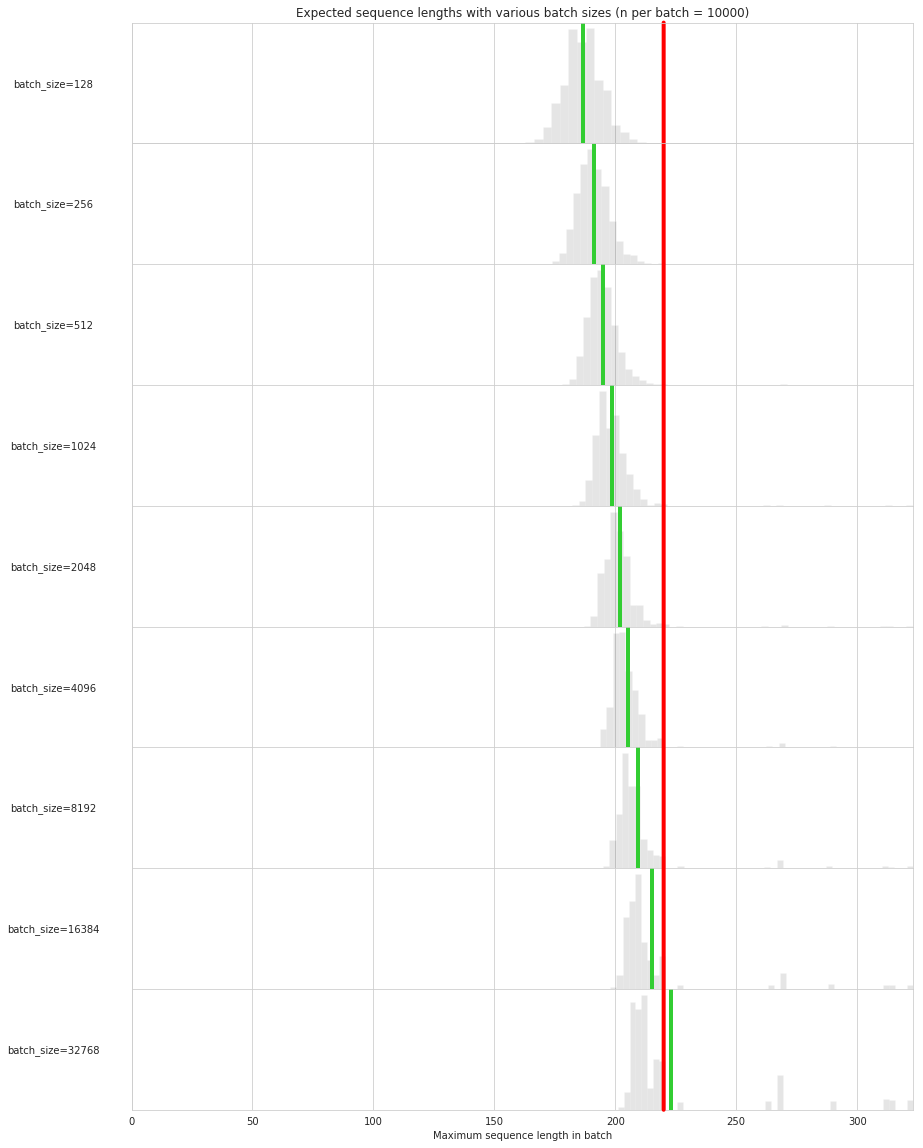

In [8]:
batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

expected_lengths = plot_expected_lengths(lengths, batch_sizes, lambda lengths: lengths.max(), markers=[MAX_LEN])
plt.xlabel('Maximum sequence length in batch')
print()

The expected batch length increases with the batch size. It even surpasses the maximum length of 220 at batch_size=32768, and it is significantly smaller than the fixed padding at a reasonable batch size of e. g. 512. When looking at the histogram, you can also see very well that the number of outliers increases when increasing the batch size. Because we are padding to the maximum length, the expected batch size is strongly influenced by outliers.

Note that the difference between the green line and the red line for each batch size does not directly relate to the speedup; there is some small overhead to dynamically padding the sequences.

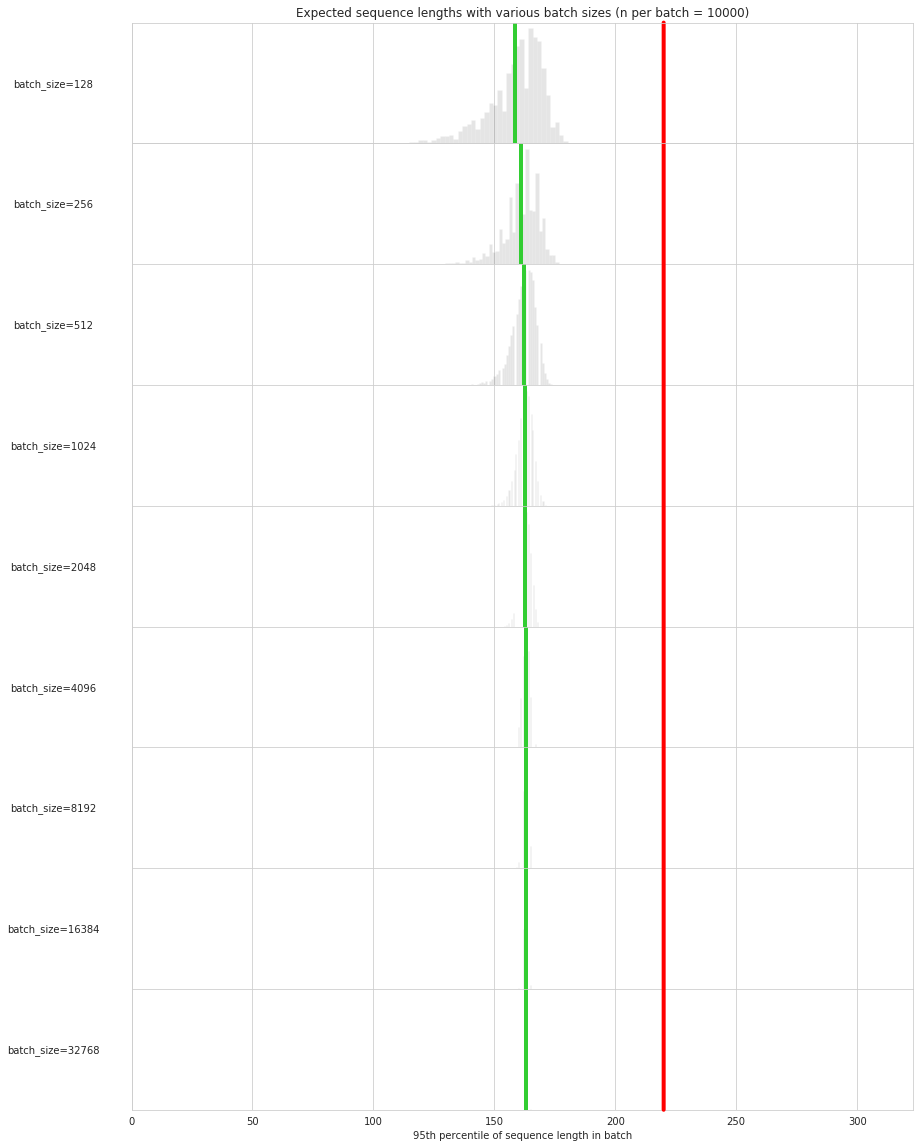

In [9]:
expected_lengths = plot_expected_lengths(lengths, batch_sizes, lambda lengths: np.percentile(lengths, q=95), markers=[MAX_LEN])
plt.xlabel('95th percentile of sequence length in batch')
print()

When padding to the 95th percentile of batch lengths instead, we can see another interesting pattern. The expected sequence length does not change that much when increasing batch size because it is more robust to outliers. In fact, it very quickly approaches the 95th percentile of lengths in the whole dataset!

In [10]:
np.percentile(lengths, q=95)

163.0

So it is questionable whether it makes sense to use sequence bucketing when padding to some percentile of the lengths for this dataset. We could just as well statically pad to the length at that percentile. 

But it definitely does make sense if we want to get the last bit of performance out of our model and don't want to loose any information by truncating sequences. And it is still faster than the static padding of 220 with reasonably small batch sizes in that case.

Next, I'll compare different methods of sequence bucketing and check which one is fastest. If you just want to see the results using the best method you can skip this section.

# Which method of sequence bucketing should I use?

I'm going to compare 3 methods:
1. The one used in [@authmans great kernel](https://www.kaggle.com/authman/simple-lstm-pytorch-with-batch-loading). Uses a custom dataset that stores the text as regular list with variable lengths and implements sequence bucketing in a `collate_fn` in the data loader.
2. The version I originally used in this kernel (version 1). Does sequence bucketing and splitting the data in batches on a dataset level. The data loader just always has a batch size of 1.
3. A new version which uses a `collate_fn` in the data loader to change already padded sequences to variable-length batches. The dataset used is just a regular `TensorDataset`. Can be used as a drop-in replacement to static padding (and it is, as you'll see, the fastest).

The time it takes to iterate over the whole train dataset will be recorded for each of these methods when padding to the maximum length in a batch.

## Method 1: TextDataset with collate_fn

Copied from [@authmans kernel](https://www.kaggle.com/authman/simple-lstm-pytorch-with-batch-loading). The only difference is that the data is not moved to the GPU to be able to compare it with the other methods. Remember to upvote that kernel :)

A custom `collate_fn` is used in the DataLoader. The collate function takes a list of all samples in the batch as input and combines these to form one batch. This way, we can easily implement sequence bucketing in the data loader leaving the dataset untouched.

In [11]:
batch_size = 512

In [12]:
class TextDataset(data.Dataset):
    def __init__(self, text, lens, y=None):
        self.text = text
        self.lens = lens
        self.y = y

    def __len__(self):
        return len(self.lens)

    def __getitem__(self, idx):
        if self.y is None:
            return self.text[idx], self.lens[idx]
        return self.text[idx], self.lens[idx], self.y[idx]
    
class Collator(object):
    def __init__(self, test=False, percentile=100):
        self.test = test
        self.percentile = percentile
        
    def __call__(self, batch):
        global MAX_LEN
        
        if self.test:
            texts, lens = zip(*batch)
        else:
            texts, lens, target = zip(*batch)

        lens = np.array(lens)
        max_len = min(int(np.percentile(lens, self.percentile)), MAX_LEN)
        texts = torch.tensor(sequence.pad_sequences(texts, maxlen=max_len), dtype=torch.long)
        
        if self.test:
            return texts
        
        return texts, torch.tensor(target, dtype=torch.float32)

In [13]:
train_collate = Collator(percentile=100)
train_dataset = TextDataset(x_train, lengths, y_train_torch.numpy())
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, collate_fn=train_collate)

In [14]:
n_repeats = 10

start_time = time.time()
for _ in range(n_repeats):
    for batch in tqdm(train_loader):
        pass
method1_time = (time.time() - start_time) / n_repeats

## Method 2: SequenceDataset with default loader

The method used in version 1 of this kernel. Uses a custom dataset to do all the work (sequence bucketing, splitting in batches, shuffling). The data loader then just has a batch size of 1.

In [15]:
class SequenceDataset(torch.utils.data.Dataset):
    """
    Dataset using sequence bucketing to pad each batch individually.
    
    Arguments:
        sequences (list): A list of variable length tokens (e. g. from keras tokenizer.texts_to_sequences)
        choose_length (function): A function which receives a numpy array of sequence lengths of one batch as input
                                  and returns the length this batch should be padded to.
        other_features (list, optional): A list of tensors with other features that should be fed to the NN alongside the sequences.
        labels (Tensor, optional): A tensor with labels for the samples.
        indices (np.array, optional): A numpy array consisting of indices to iterate over. 
        shuffle (bool): Whether to shuffle the dataset or not.  Default false.
        batch_size (int): Batch size of the samples. Default 512.
    """
    def __init__(self, sequences, choose_length, other_features=None, labels=None, 
                 indices=None, shuffle=False, batch_size=512):
        super(SequenceDataset, self).__init__()
        
        self.sequences = np.array(sequences)
        self.lengths = np.array([len(x) for x in sequences])
        self.n_samples = len(sequences)
        self.choose_length = choose_length
        self.other_features = other_features
        self.labels = labels
        
        if indices is not None:
            self.indices = indices
        else:
            self.indices = np.arange(len(sequences))
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if self.shuffle:
            self._shuffle()
        
    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)
        
    def _shuffle(self):
        self.indices = np.random.permutation(self.indices)
    
    def __getitem__(self, i):
        idx = self.indices[(self.batch_size * i):(self.batch_size * (i + 1))]
        
        if self.shuffle and i == len(self) - 1:
            self._shuffle()
        
        pad_length = math.ceil(self.choose_length(self.lengths[idx]))
        padded_sequences = sequence.pad_sequences(self.sequences[idx], maxlen=pad_length)
        
        x_batch = [torch.tensor(padded_sequences, dtype=torch.long)]

        if self.other_features is not None:
            x_batch += [x[idx] for x in self.other_features]
            
        if self.labels is not None:
            out = x_batch, self.labels[idx]
        else:
            out = x_batch
    
        return out

In [16]:
train_dataset = SequenceDataset(x_train, lambda lengths: lengths.max(), other_features=[lengths], shuffle=False, batch_size=batch_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

In [17]:
n_repeats = 10

start_time = time.time()
for _ in range(n_repeats):
    for batch in tqdm(train_loader):
        pass
method2_time = (time.time() - start_time) / n_repeats

## Method 3: Default TensorDataset with custom collate_fn

A new method using the DataLoader `collate_fn` for sequence bucketing that works with a regular `TensorDataset`.

In [18]:
lengths = torch.from_numpy(np.array([len(x) for x in x_train]))

maxlen = lengths.max() 
x_train_padded = torch.from_numpy(sequence.pad_sequences(x_train, maxlen=maxlen))
x_train_padded.shape

torch.Size([1804874, 323])

In [19]:
class SequenceBucketCollator():
    def __init__(self, choose_length, sequence_index, length_index, label_index=None):
        self.choose_length = choose_length
        self.sequence_index = sequence_index
        self.length_index = length_index
        self.label_index = label_index
        
    def __call__(self, batch):
        batch = [torch.stack(x) for x in list(zip(*batch))]
        
        sequences = batch[self.sequence_index]
        lengths = batch[self.length_index]
        
        length = self.choose_length(lengths)
        mask = torch.arange(start=maxlen, end=0, step=-1) < length
        padded_sequences = sequences[:, mask]
        
        batch[self.sequence_index] = padded_sequences
        
        if self.label_index is not None:
            return [x for i, x in enumerate(batch) if i != self.label_index], batch[self.label_index]
    
        return batch

In [20]:
dataset = data.TensorDataset(x_train_padded, lengths, y_train_torch)
train_loader = data.DataLoader(dataset, batch_size=batch_size, collate_fn=SequenceBucketCollator(lambda x: x.max(), 0, 1, 2))

In [21]:
n_repeats = 10

start_time = time.time()
for _ in range(n_repeats):
    for batch in tqdm(train_loader):
        pass
method3_time = (time.time() - start_time) / n_repeats

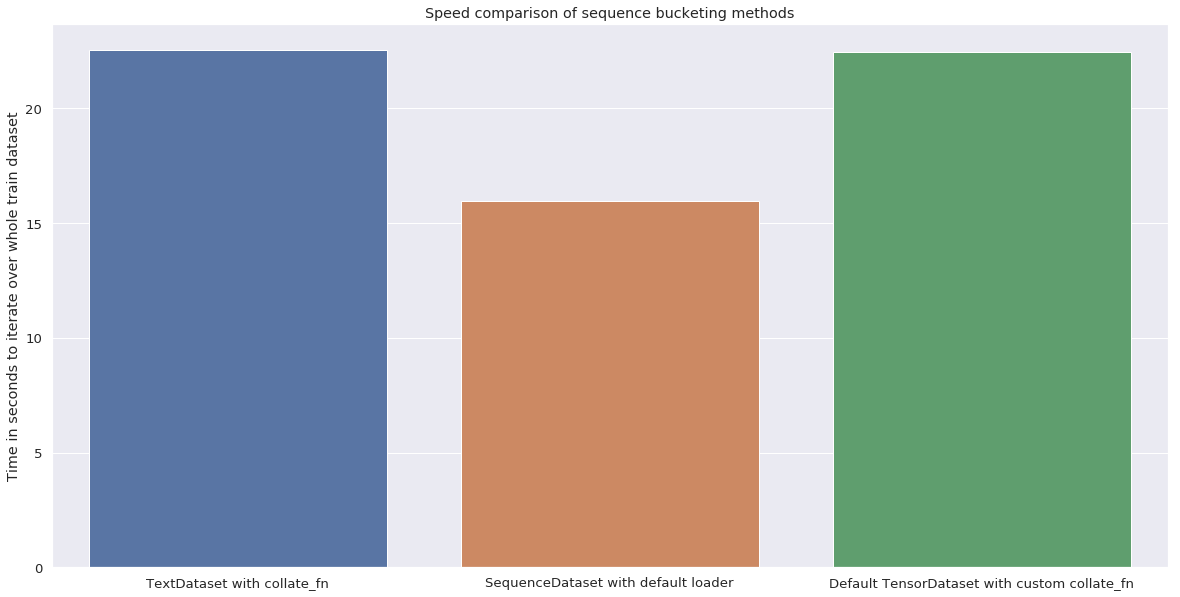

In [22]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.2)
barplot = sns.barplot(x=[
    'TextDataset with collate_fn', 
    'SequenceDataset with default loader', 
    'Default TensorDataset with custom collate_fn'], y=[
    method1_time,
    method2_time,
    method3_time
])

plt.title('Speed comparison of sequence bucketing methods')
plt.ylabel('Time in seconds to iterate over whole train dataset')
print()

Method 1 is quite a bit solower than the rest, but method 2 and 3 are pretty close to each other (keep in mind that the majority of the time it takes to train the NN is spent in the actual computation anyway, not while loading). I am going to use method 3 because it is much more elegant and can be used as a drop-in replacement to static padding.

# Implementation & comparing static padding with sequence bucketing

The `train_model` function is exactly the same. The NN itself is also only slightly different. It also accepts an optional `lengths` parameter because lengths are part of the dataset now.

In [23]:
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix, num_aux_targets):
        super(NeuralNet, self).__init__()
        embed_size = embedding_matrix.shape[1]
        
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = SpatialDropout(0.3)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)
    
        self.linear1 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(DENSE_HIDDEN_UNITS, DENSE_HIDDEN_UNITS)
        
        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, 1)
        self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        
    def forward(self, x, lengths=None):
        h_embedding = self.embedding(x.long())
        h_embedding = self.embedding_dropout(h_embedding)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        # global average pooling
        avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        max_pool, _ = torch.max(h_lstm2, 1)
        
        h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_conc))
        h_conc_linear2  = F.relu(self.linear2(h_conc))
        
        hidden = h_conc + h_conc_linear1 + h_conc_linear2
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

It's time for some benchmarks! I am going to compare the time it takes to predict the whole train dataset using:
- static padding (max_len=220)
- sequence bucketing (maximum length)
- static padding (to 95th percentile of lengths)
- sequence bucketing (to 95th percentile of lengths)

All with a batch size of 512. You can see the result below.

In [24]:
batch_size = 512

model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
model.cuda()

# sequence bucketing - max length
train_dataset = data.TensorDataset(x_train_padded, lengths, y_train_torch)
collator = SequenceBucketCollator(lambda lengths: lengths.max(), 0, 1, 2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False, collate_fn=collator)

start_time = time.time()
for x_batch in tqdm(train_loader):
    model(x_batch[0][0].cuda())
max_length_seq_bucketing_time = time.time() - start_time

# sequence bucketing - 95th percentile of lenghts
train_dataset = data.TensorDataset(x_train_padded, lengths, y_train_torch)
collator = SequenceBucketCollator(lambda lengths: np.percentile(lengths.numpy(), q=95), 0, 1, 2)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False, collate_fn=collator)
start_time = time.time()
for x_batch in tqdm(train_loader):
    model(x_batch[0][0].cuda())
percentile_seq_bucketing_time = time.time() - start_time

# static padding - maxlen of 220
x_train_padded = torch.tensor(sequence.pad_sequences(x_train, maxlen=MAX_LEN))
train_dataset = data.TensorDataset(x_train_padded)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

start_time = time.time()
for x_batch in tqdm(train_loader):
    model(x_batch[0].cuda())
maxlen_static_time = time.time() - start_time

# static padding - 95th percentile
percentile_length = math.ceil(np.percentile(lengths, q=95))
x_train_padded = torch.tensor(sequence.pad_sequences(x_train, maxlen=percentile_length))
train_dataset = data.TensorDataset(x_train_padded)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

start_time = time.time()
for x_batch in tqdm(train_loader):
    model(x_batch[0].cuda())
percentile_static_time = time.time() - start_time

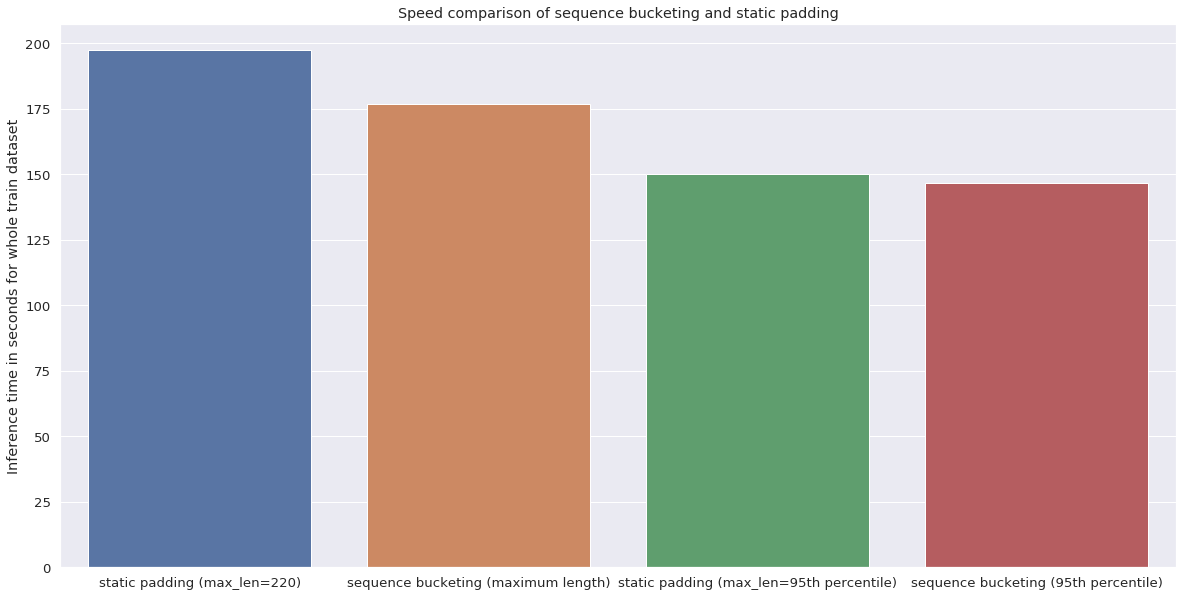

In [25]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.2)
barplot = sns.barplot(x=[
    'static padding (max_len=220)', 
    'sequence bucketing (maximum length)', 
    'static padding (max_len=95th percentile)', 
    'sequence bucketing (95th percentile)'], y=[
    maxlen_static_time,
    max_length_seq_bucketing_time,
    percentile_static_time,
    percentile_seq_bucketing_time    
])

plt.title('Speed comparison of sequence bucketing and static padding')
plt.ylabel('Inference time in seconds for whole train dataset')
print()

# Training

For training in this kernel, I will use sequence bucketing with maximum length.

Now we can instantiate a test, train and valid dataset and train the network. The validation dataset is only added so that the fast.ai DataBunch works as expected and it consists of only 2 samples.

In [26]:
lengths = torch.from_numpy(np.array([len(x) for x in x_train]))
test_lengths = torch.from_numpy(np.array([len(x) for x in x_test]))
maxlen = lengths.max() 

x_train_padded = torch.from_numpy(sequence.pad_sequences(x_train, maxlen=maxlen))
x_test_padded = torch.from_numpy(sequence.pad_sequences(x_test, maxlen=maxlen))

In [27]:
batch_size = 512

test_dataset = data.TensorDataset(x_test_padded, test_lengths)
train_dataset = data.TensorDataset(x_train_padded, lengths, y_train_torch)
valid_dataset = data.Subset(train_dataset, indices=[0, 1])

train_collator = SequenceBucketCollator(lambda lenghts: lenghts.max(), 
                                        sequence_index=0, 
                                        length_index=1, 
                                        label_index=2)
test_collator = SequenceBucketCollator(lambda lenghts: lenghts.max(), sequence_index=0, length_index=1)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_collator)
valid_loader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=train_collator)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=test_collator)

databunch = DataBunch(train_dl=train_loader, valid_dl=valid_loader, collate_fn=train_collator)

In [28]:
def custom_loss(data, targets):
    ''' Define custom loss function for weighted BCE on 'target' column '''
    bce_loss_1 = nn.BCEWithLogitsLoss(weight=targets[:,1:2])(data[:,:1],targets[:,:1])
    bce_loss_2 = nn.BCEWithLogitsLoss()(data[:,1:],targets[:,2:])
    return (bce_loss_1 * loss_weight) + bce_loss_2

Now, train the model and see that it is faster than before!

On my local machine, one epoch with statically padded sequences takes 7:25 to train (445 seconds). With sequence bucketing, one batch takes 6:26 (386 seconds). So the version with sequence bucketing is 1.15x faster.

In [29]:
all_test_preds = []

for model_idx in range(NUM_MODELS):
    print('Model ', model_idx)
    seed_everything(1234 + model_idx)
    model = NeuralNet(embedding_matrix, y_aux_train.shape[-1])
    learn = Learner(databunch, model, loss_func=custom_loss)
    test_preds = train_model(learn,test_dataset,output_dim=7)    
    all_test_preds.append(test_preds)

Model  0
epoch     train_loss  valid_loss  time    
0         0.279220    0.008495    08:30     
Total time: 08:30
epoch     train_loss  valid_loss  time    
0         0.274950    0.005631    08:29     
Total time: 08:29
epoch     train_loss  valid_loss  time    
0         0.265239    0.008325    08:29     
Total time: 08:29
epoch     train_loss  valid_loss  time    
0         0.259042    0.006958    08:30     
Total time: 08:30
Model  1
epoch     train_loss  valid_loss  time    
0         0.280941    0.004127    08:28     
Total time: 08:28
epoch     train_loss  valid_loss  time    
0         0.268860    0.007016    08:28     
Total time: 08:28
epoch     train_loss  valid_loss  time    
0         0.259153    0.009856    08:28     
Total time: 08:28
epoch     train_loss  valid_loss  time    
0         0.258198    0.005004    08:28     
Total time: 08:28


In [30]:
submission = pd.DataFrame.from_dict({
    'id': test['id'],
    'prediction': np.mean(all_test_preds, axis=0)[:, 0]
})

submission.to_csv('submission.csv', index=False)

# Where to go from here

In this kernel, I have shown the simplest possible method of sequence bucketing. There are also other methods, notably splitting the dataset itself into buckets consisting of samples with similar length and then taking all samples in a batch from one of those buckets instead of randomly choosing samples for a batch. This was introduced in [this paper](https://arxiv.org/abs/1708.05604).

Implementing this method could potentially speed the training up even more.

Sequence bucketing could also be used to speed up the training of BERT. I don't have that much experience with BERT, but from what I have seen, samples are paddded statically in the popular [PyTorch implementation of BERT](https://github.com/huggingface/pytorch-pretrained-BERT). You might be able to train BERT significantly faster using sequence bucketing.

Thanks for reading!